In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt # for making figures
%matplotlib inline

In [2]:
# read in all the words
words = open('names.txt', 'r').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [3]:
len(words)

32033

In [4]:
# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
print(itos)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


In [5]:
# build the dataset

block_size = 3 # context length: how many characters do we take to predict the next one?
X, Y = [], []
for w in words:
  
  #print(w)
  context = [0] * block_size
  for ch in w + '.':
    ix = stoi[ch]
    X.append(context)
    Y.append(ix)
    #print(''.join(itos[i] for i in context), '--->', itos[ix])
    context = context[1:] + [ix] # crop and append

  
X = torch.tensor(X)
Y = torch.tensor(Y)

In [6]:
X.shape, X.dtype, Y.shape, Y.dtype

(torch.Size([228146, 3]), torch.int64, torch.Size([228146]), torch.int64)

In [7]:
# build the dataset
block_size = 3 # context length: how many characters do we take to predict the next one?

def build_dataset(words):  
  X, Y = [], []
  for w in words:

    #print(w)
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      #print(''.join(itos[i] for i in context), '--->', itos[ix])
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])


torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [8]:
C = torch.randn((27, 2))

In [9]:
X.shape

torch.Size([228146, 3])

In [10]:
emb = C[X]   # very important for every 228146 *3 we have size of vector 2 
emb.shape

torch.Size([228146, 3, 2])

In [11]:
W1 = torch.randn((6, 100))
b1 = torch.randn(100)

In [12]:
h = torch.tanh(emb.view(-1, 6) @ W1 + b1) 

In [13]:
print((emb.view(-1, 6) @ W1).shape)
b1.shape
# In this broadcasting 
# 228146 100
#    1     100
# since same bias vector is adding in all the rows so it's correct.

torch.Size([228146, 100])


torch.Size([100])

In [14]:
h

tensor([[ 0.9398, -0.7526,  0.3632,  ..., -0.6581, -0.5604, -0.7998],
        [ 0.9797,  0.2122,  0.7429,  ..., -0.9170, -0.9430, -0.8568],
        [ 0.8291, -0.2994,  0.6713,  ..., -0.8762,  0.5861, -0.9658],
        ...,
        [ 0.9984,  0.9915,  0.2934,  ..., -0.3338, -0.9920, -0.8993],
        [ 0.4876,  0.9575,  0.8537,  ..., -0.9902,  0.9996, -0.9965],
        [ 0.9997, -0.7052, -0.6409,  ...,  0.9994, -0.9909,  0.5187]])

In [15]:
h.shape

torch.Size([228146, 100])

In [16]:
W2 = torch.randn((100, 27))
b2 = torch.randn(27)

In [17]:
logits = h @ W2 + b2

In [18]:
logits.shape

torch.Size([228146, 27])

In [19]:
counts = logits.exp()
counts.shape

torch.Size([228146, 27])

In [20]:
prob = counts / counts.sum(1, keepdims=True)
prob.shape

torch.Size([228146, 27])

In [21]:
loss = -prob[torch.arange(prob.shape[0]), Y].log().mean()
loss

tensor(16.5185)

In [22]:
logits=torch.tensor([-5,-3,1000])
counts=logits.exp()
prob=counts/counts.sum()
prob
# If we have a large number then we have a inf in output becuse of exp
# but in cross entopy function in pytorch we subtract every number by the max number 
# because it does not make any diff in prob

#Cross entropy Advantage
# 1. effiecieny in forward pass and backward pass
# 2. Numerically more stable

tensor([0., 0., nan])

In [23]:
counts

tensor([0.0067, 0.0498,    inf])

In [24]:
# ------------ now made respectable :) ---------------

In [25]:
Xtr.shape, Ytr.shape # dataset

(torch.Size([182625, 3]), torch.Size([182625]))

In [26]:
g = torch.Generator().manual_seed(2147483647) # for reproducibility
C = torch.randn((27, 10), generator=g)
W1 = torch.randn((30, 200), generator=g)
b1 = torch.randn(200, generator=g)
W2 = torch.randn((200, 27), generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2]

In [27]:
sum(p.nelement() for p in parameters) # number of parameters in total

11897

In [28]:
for p in parameters:
  p.requires_grad = True

In [29]:
lre = torch.linspace(-3, 0, 1000)
lrs = 10**lre

In [30]:
lri = []
lossi = []
stepi = []

In [38]:
ix = torch.randint(0, Xtr.shape[0], (32,)) 

torch.Size([32, 3, 10])

In [31]:
max_steps=200000
for i in range(max_steps):
  
  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (32,))  # size of a minibatch is  32 and it should be in tuple
  
  # forward pass
  emb = C[Xtr[ix]] # (32, 3, 10)
  h = torch.tanh(emb.view(-1, 30) @ W1 + b1) # (32, 200)
  logits = h @ W2 + b2 # (32, 27)
  loss = F.cross_entropy(logits, Ytr[ix])   # F.cross_entropy is more effiecient
  #print(loss.item())
  
  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()
  
  # update
  #lr = lrs[i]
  lr = 0.1 if i < 100000 else 0.01
  for p in parameters:
    p.data += -lr * p.grad
  if i%10000==0:
    print(f'{i:7d}/{max_steps:7d}:{loss.item():.4f}')
  # track stats
  #lri.append(lre[i])
  stepi.append(i)
  lossi.append(loss.log10().item())     # 

#print(loss.item())

      0/ 200000:21.9281
  10000/ 200000:2.7366
  20000/ 200000:2.6281
  30000/ 200000:2.6879
  40000/ 200000:2.2267
  50000/ 200000:2.4246
  60000/ 200000:2.1974
  70000/ 200000:2.5681
  80000/ 200000:2.3000
  90000/ 200000:2.2295
 100000/ 200000:2.4270
 110000/ 200000:2.1735
 120000/ 200000:2.3098
 130000/ 200000:1.6229
 140000/ 200000:2.0753
 150000/ 200000:1.9840
 160000/ 200000:1.7689
 170000/ 200000:2.1857
 180000/ 200000:2.1779
 190000/ 200000:2.2475


In [34]:
# If we see the inital loss is very high
# and if we observe what can be the maximum loss is 
-torch.tensor(1/27).log()
# because the prob dist for very 27 should be equal at the start
# But right now what's happening is that the network is very confidently wrong about the predictions because at logits are very high
# so at the time of the softmax what is happening is that we are low values for the correct class.

tensor(3.2958)

In [59]:
x=torch.tensor([[2,2,2,2],[3,3,3,50]]).float()
exp=x.exp()
prob=exp/exp.sum(1,keepdim=True)
prob2=torch.softmax(x,dim=1)
print(prob)
print(-prob2[1][1].log())
# for 2nd row we are getting very high loss.

# we solve it in the MLP visited cell in 3 part please go through it 

tensor([[2.5000e-01, 2.5000e-01, 2.5000e-01, 2.5000e-01],
        [3.8740e-21, 3.8740e-21, 3.8740e-21, 1.0000e+00]])
tensor(47.)


In [45]:
exp.sum(1,keepdim=True).shape

torch.Size([2, 1])

In [ ]:
# 2 4 

In [121]:
loss

tensor(1.9736, grad_fn=<NllLossBackward0>)

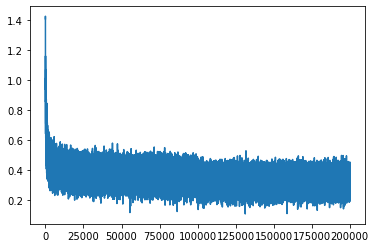

In [122]:
plt.plot(stepi, lossi)

In [797]:
emb = C[Xtr] # (32, 3, 2)
h = torch.tanh(emb.view(-1, 30) @ W1 + b1) # (32, 100)
logits = h @ W2 + b2 # (32, 27)
loss = F.cross_entropy(logits, Ytr)
loss

tensor(2.1260, grad_fn=<NllLossBackward0>)

In [798]:
emb = C[Xdev] # (32, 3, 2)
h = torch.tanh(emb.view(-1, 30) @ W1 + b1) # (32, 100)
logits = h @ W2 + b2 # (32, 27)
loss = F.cross_entropy(logits, Ydev)
loss

tensor(2.1701, grad_fn=<NllLossBackward0>)

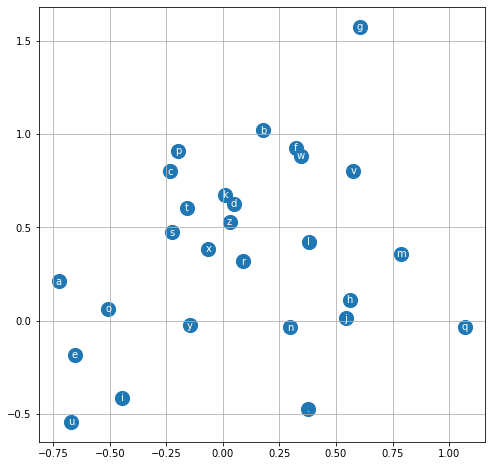

In [710]:
# visualize dimensions 0 and 1 of the embedding matrix C for all characters
plt.figure(figsize=(8,8))
plt.scatter(C[:,0].data, C[:,1].data, s=200)
for i in range(C.shape[0]):
    plt.text(C[i,0].item(), C[i,1].item(), itos[i], ha="center", va="center", color='white')
plt.grid('minor')

In [ ]:
# training split, dev/validation split, test split
# 80%, 10%, 10%

In [805]:
context = [0] * block_size
C[torch.tensor([context])].shape

torch.Size([1, 3, 10])

In [820]:
# sample from the model
g = torch.Generator().manual_seed(2147483647 + 10)
for _ in range(20):
    out = []
    context = [0] * block_size # initialize with all ...
    while True:
      emb = C[torch.tensor([context])] # (1,block_size,d)
      h = torch.tanh(emb.view(1, -1) @ W1 + b1)
      logits = h @ W2 + b2
      probs = F.softmax(logits, dim=1)
      ix = torch.multinomial(probs, num_samples=1, generator=g).item()
      context = context[1:] + [ix]
      out.append(ix)
      if ix == 0:
        break
    print(''.join(itos[i] for i in out))

carmahela.
jhovi.
kimrin.
thil.
halanna.
jazhien.
amerynci.
aqui.
nellara.
chaiiv.
kaleigh.
ham.
joce.
quinton.
lilea.
jamilio.
jeron.
jaryni.
jace.
chrudeley.
